<a href="https://colab.research.google.com/github/Jcrawford77/Foreign-Object-Detection/blob/NEWEST/working.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
using_colab = True

SAM setup code

In [44]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124
CUDA is available: False
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-s3fe39_x
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-s3fe39_x
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
mkdir: cannot create directory ‘images’: File exists
--2025-07-16 19:40:08--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99846 (98K) [image/jpeg]
Saving to: ‘images/dog.jpg.2’

do

# Env Setup

In [45]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import numpy as np
#Install rasterio
%pip install rasterio
import rasterio
import pandas as pd

END of SAM setup

# Colour coding masks ( needs to be moved down the notebook FYI)

In [46]:
#code should be moved to later in notebook
#function to colour code the later generated masks
def show_anns(anns):
    if len(anns) == 0:
        return

    #Sort by area in descending order for better visualization, applies larger masks first so smaller masks don't get hidden
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0

    # Define colors for building and not building masks
    building_color = np.array([0., 1., 0., 0.35])  # Green with transparency
    not_building_color = np.array([1., 0., 0., 0.35]) # Red with transparency

    #IF statement assigning colours to masks
    for ann in sorted_anns:
        m = ann['segmentation']
        label = ann.get('label', 'unknown')

        if label == 'building':
            color_mask = building_color
        elif label == 'not building':
            color_mask = not_building_color
        else:
            #Use random color for others
            color_mask = np.concatenate([np.random.random(3), [0.35]])

        img[m] = color_mask
    ax.imshow(img)

# Image Upload

In [47]:
#Image upload for 3 band imagery
from PIL import Image

#Added the images within the repo, you may need to upload to imagery directory on left hand side of files
img_pil = Image.open('images/Building_MVP_Composite.tif')

#Convert the Pillow image to a NumPy array that OpenCV can use
image = np.array(img_pil)

#If the image is grayscale or has an alpha channel, need to convert it to BGR or RGB
if len(image.shape) == 2: # Grayscale
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
elif image.shape[2] == 4: #Image with alpha channel
    image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)
else: #RGB or BGR
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

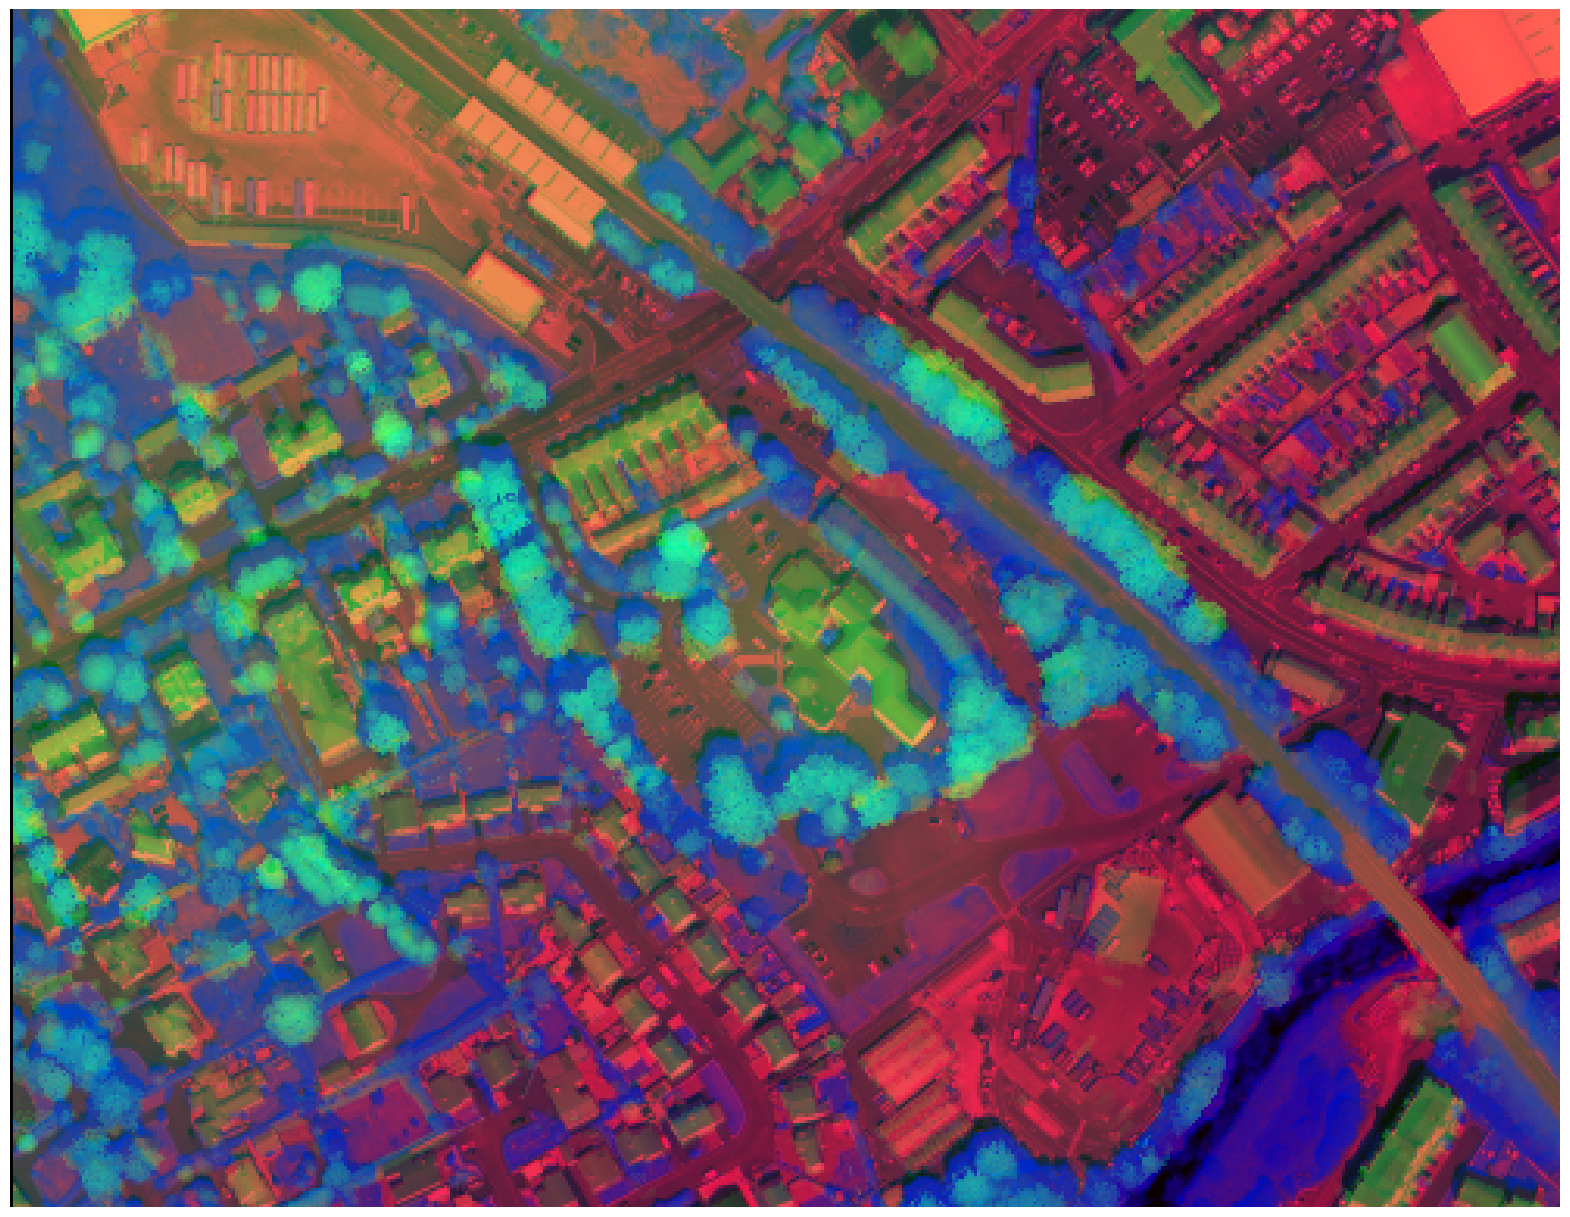

In [48]:
#plot image
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

# Mask Generation

SAM out of box setup

In [49]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

# device = "cuda"
device = "cpu" # Changed device to cpu as CUDA is not available

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [50]:
masks = mask_generator.generate(image)
print(len(masks))
print(masks[0].keys())

278
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


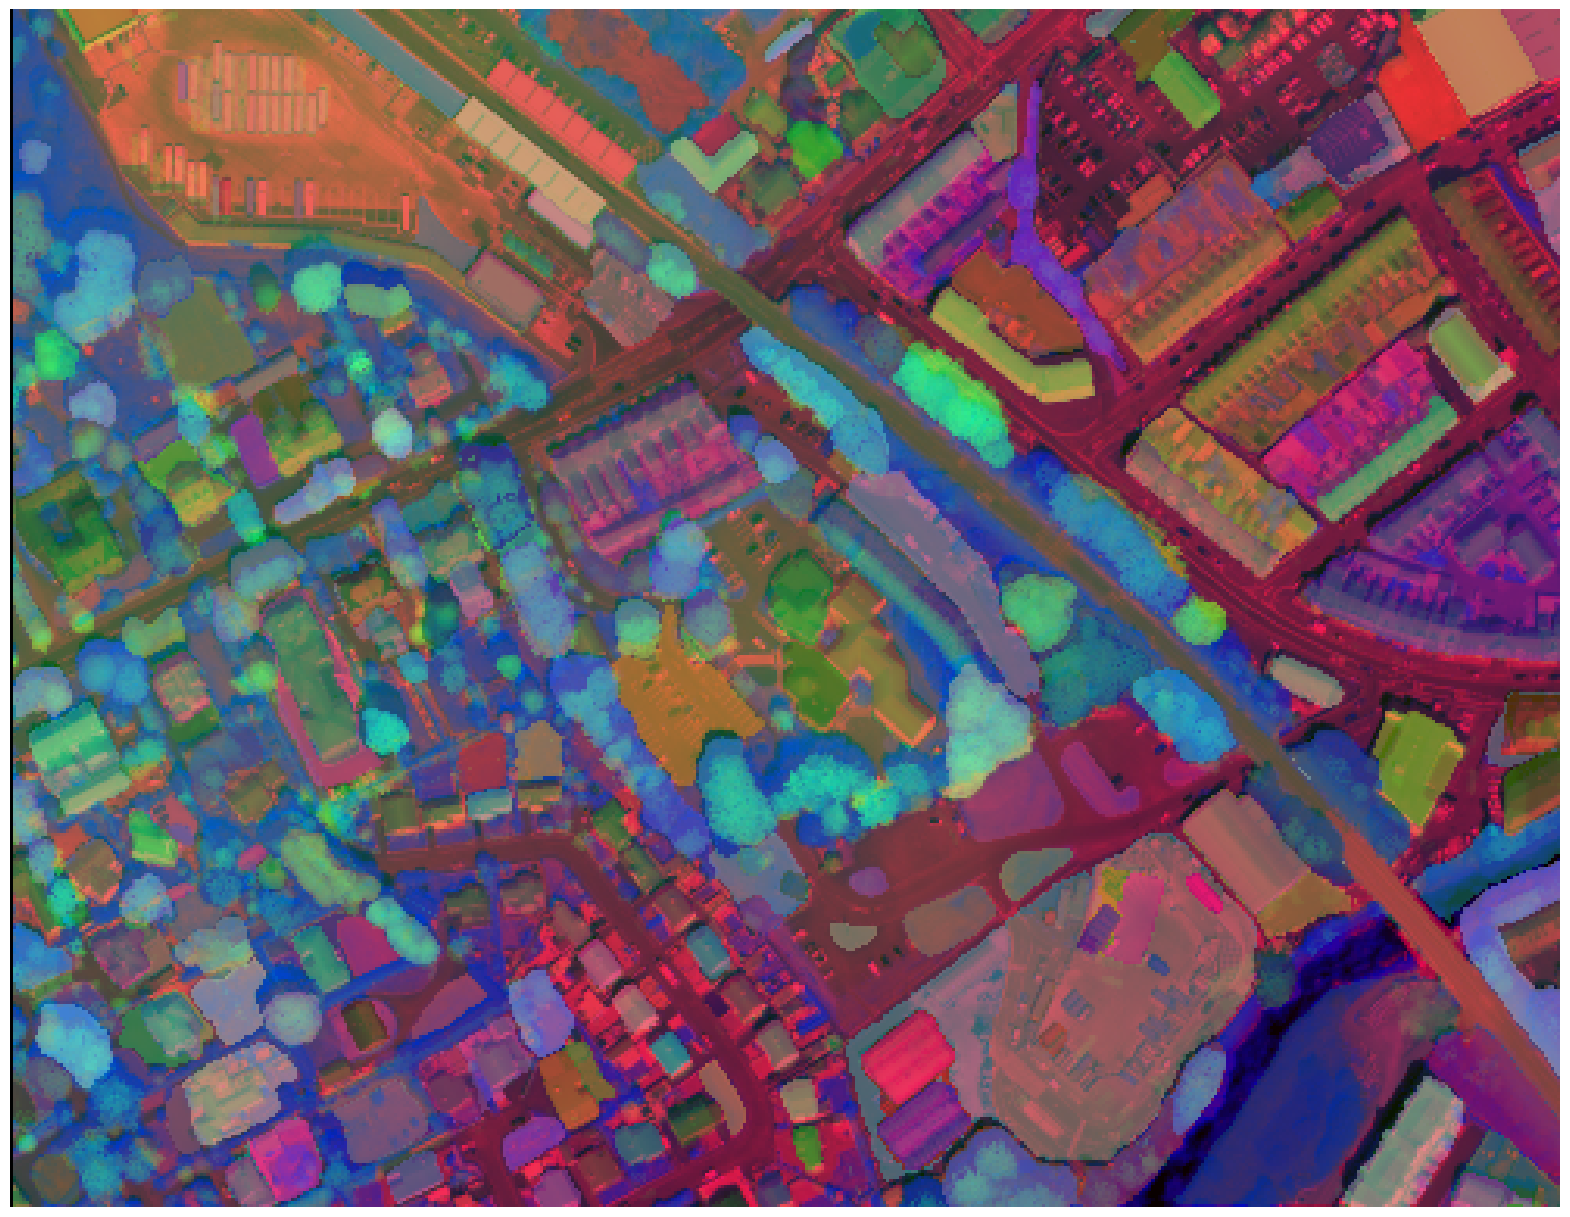

In [51]:
#Plot image
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

In [52]:
#Masks with use of thresholds
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    #pps is for number of masks, and is most useful for our use case
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,
)

In [53]:
masks2 = mask_generator_2.generate(image)

In [54]:
len(masks2)

462

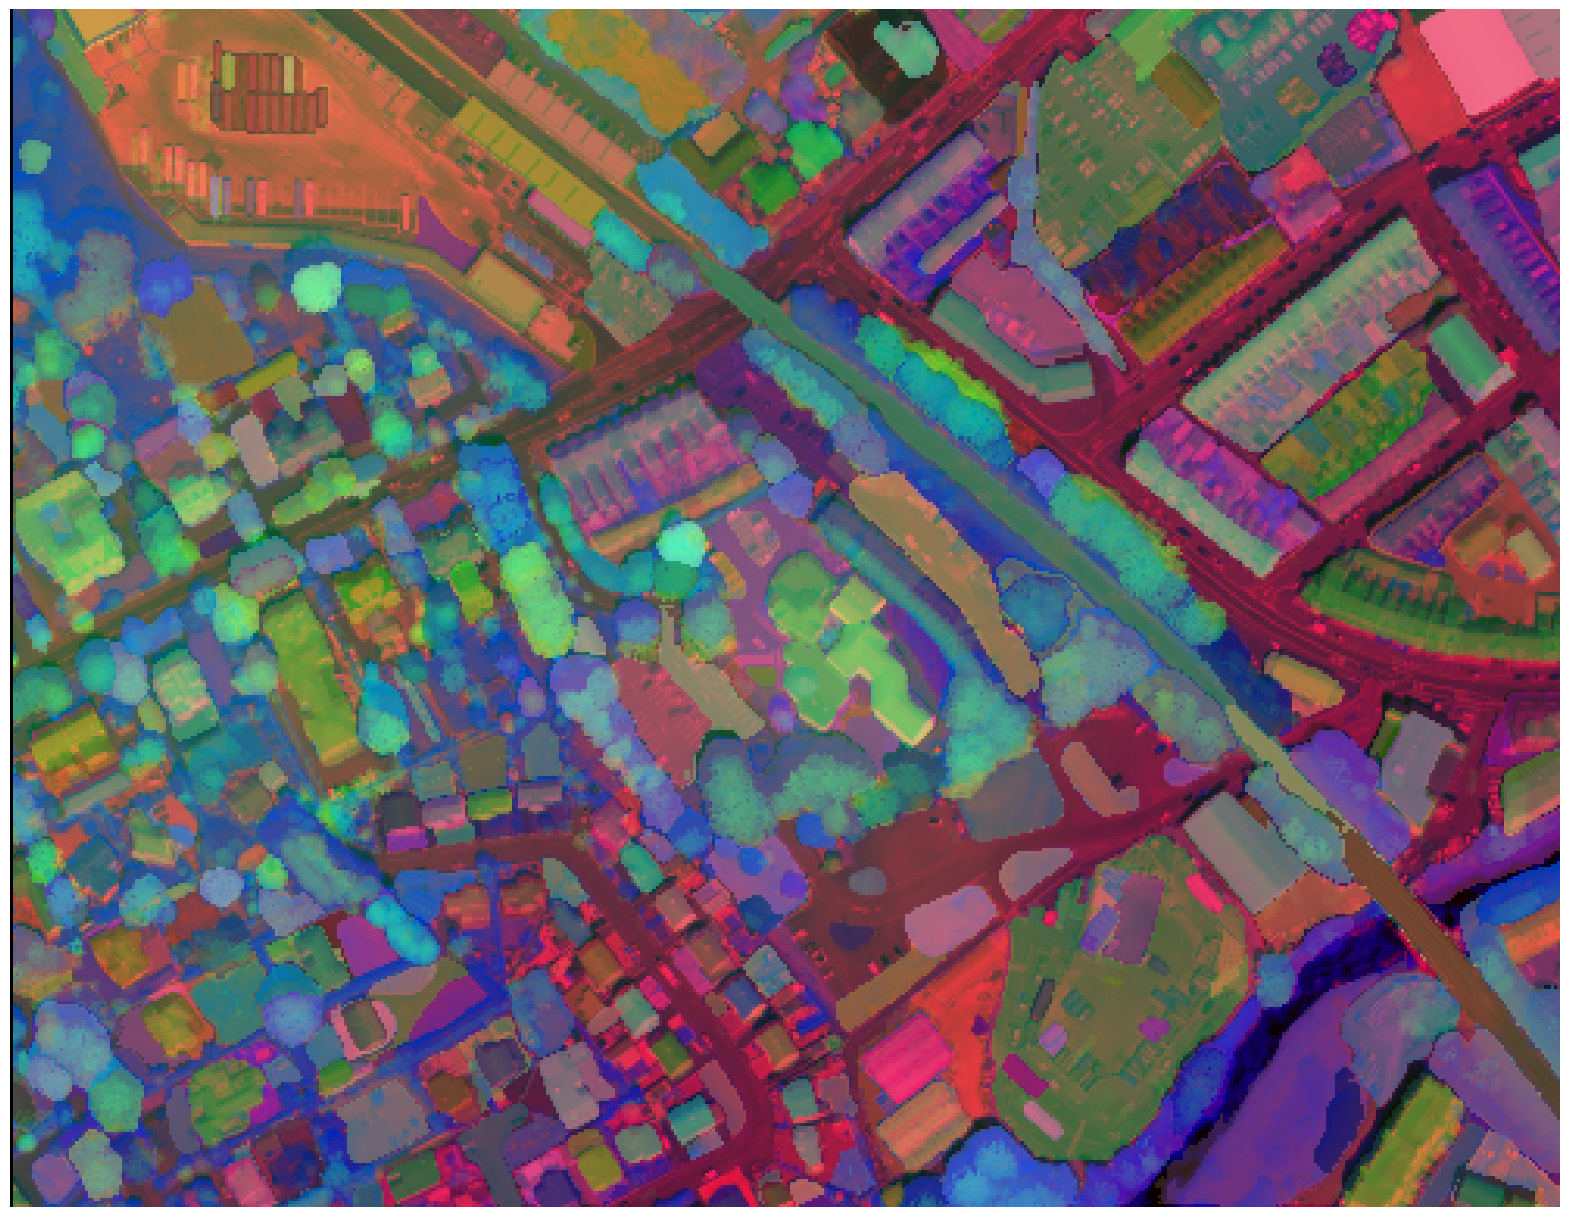

In [55]:
len(masks2)
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show()

# Add Binary Mask

In [56]:
from PIL import Image

# Load the binary mask image
binary_mask_pil = Image.open('images/BinaryMask_Resample.tif')
binary_mask = np.array(binary_mask_pil)


Intersection over union

In [57]:
# Define an overlap threshold (e.g., 50% overlap)
overlap_threshold = 0.5 # Works best in the demo looking at building ground truth
#list to store the classified masks and assigned ground truth labels
classified_masks = []
#Get the shape of the first segmentation mask to resize the binary mask allowing for comparison
if masks2:
    mask_shape = masks2[0]['segmentation'].shape
    binary_mask_resized = cv2.resize(binary_mask.astype(np.uint8), (mask_shape[1], mask_shape[0]), interpolation=cv2.INTER_NEAREST).astype(bool)
else:
    binary_mask_resized = None


#Iterate through each generated mask
if binary_mask_resized is not None:
    # Using masks2 from the previous generation
    for mask_info in masks2:
        segmentation = mask_info['segmentation']
        #Calculate the area of the mask
        mask_area = segmentation.sum()

        #Avoid division by zero and handle empty masks
        if mask_area > 0:
            intersection = np.logical_and(segmentation, binary_mask_resized).sum()
            #Calculate the overlap ratio
            overlap_ratio = intersection / mask_area

            #Classify the mask based on the overlap threshold
            if overlap_ratio > overlap_threshold:
                mask_info['label'] = 'building'
            else:
                mask_info['label'] = 'not building'
        else:
            mask_info['label'] = 'not building'

        classified_masks.append(mask_info)

Lists of masks, and ground truth labels

In [58]:
# Create lists to store the extracted data
segmentations = []
labels = []

# Iterate through each classified mask
for mask_info in classified_masks:
    #Access the segmentation mask
    segmentation = mask_info['segmentation']

    #Access the ground truth label ('building' or 'not building')
    label = mask_info['label']

    #Append the segmentation and label each own list
    segmentations.append(segmentation)
    labels.append(label)



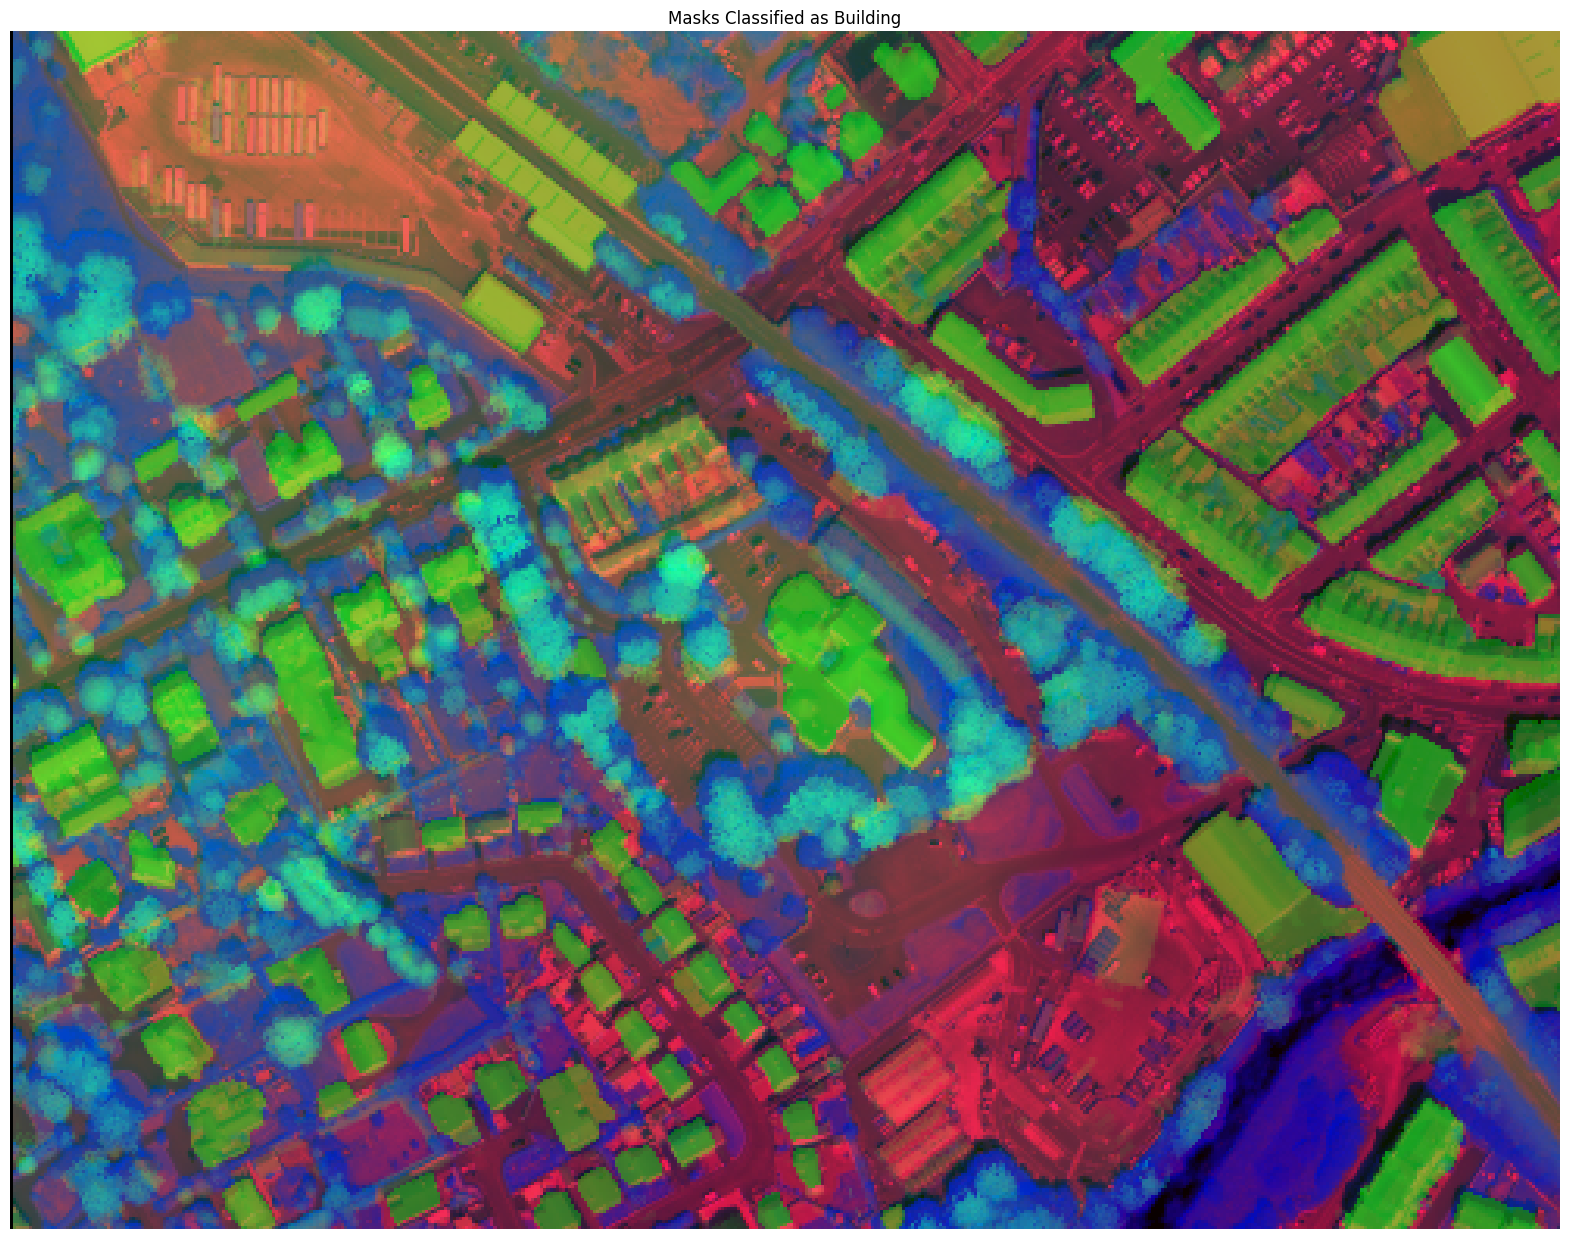

In [59]:
# Filter the classified masks to get only the buildingmasks
building_masks = [mask for mask in classified_masks if mask['label'] == 'building']

# Visualize the building masks
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(building_masks)
plt.axis('off')
plt.title('Masks Classified as Building')
plt.show()

# extract info for dataset

In [60]:
#load sample image and get metadata
original_image_path = 'images/Building_MVP_Composite.tif'

try:
    with rasterio.open(original_image_path) as src:
        # Read all bands from the image
        original_image_data = src.read()
        # Get the metadata for later use
        original_image_meta = src.meta
except rasterio.errors.RasterioIOError as errorm:
    original_image_data = None
    original_image_meta = None


In [61]:
#list to store the features and labels
features_list = []
if original_image_data is not None:
    #Iterate through each classified mask
    for i, mask_info in enumerate(classified_masks):
        segmentation = mask_info['segmentation']
        label = mask_info['label']
        masked_data = original_image_data[:, segmentation] #This extracts values for all bands where segmentation is True

        #Calculate statistics for each band within the masked area
        mask_features = {}
        mask_features['label'] = label

        #Ensure there are pixels within the mask
        if masked_data.size > 0:
             for band_idx in range(original_image_data.shape[0]):
                band_data = masked_data[band_idx, :]
                mask_features[f'band_{band_idx+1}_mean'] = np.mean(band_data)
                mask_features[f'band_{band_idx+1}_median'] = np.median(band_data)
                mask_features[f'band_{band_idx+1}_std'] = np.std(band_data)

        else:
             #Handle empty masks
             for band_idx in range(original_image_data.shape[0]):
                mask_features[f'band_{band_idx+1}_mean'] = 0
                mask_features[f'band_{band_idx+1}_median'] = 0
                mask_features[f'band_{band_idx+1}_std'] = 0


        #add area of mask
        mask_features['area'] = mask_info['area']
        #append data to list
        features_list.append(mask_features)



# organise into pandas df

In [62]:
# Convert the list of feature dictionaries into a pandas DataFrame
features_df = pd.DataFrame(features_list)

# Display the first rows of the DataFrame
display(features_df.head())


,label,band_1_mean,band_1_median,band_1_std,band_2_mean,band_2_median,band_2_std,band_3_mean,band_3_median,band_3_std,area
0,not building,103.072581,100.0,12.329432,34.784274,34.0,4.752741,117.266129,121.0,24.207223,496
1,building,70.438554,70.0,5.541124,45.361446,48.0,12.862740,142.587952,136.0,32.436204,415
2,not building,118.276786,119.0,9.305058,44.584821,45.0,1.192215,83.857143,83.0,11.886259,224
3,not building,161.061033,166.0,17.292866,157.511737,168.0,38.071543,35.352113,34.0,17.227638,213
4,building,68.421659,65.0,9.752211,137.676267,143.0,19.393097,109.010369,105.5,36.304824,868


# Classification Model - Random Forest

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Separate predictor variables
X = features_df.drop('label', axis=1)
y = features_df['label']

# Convert predictors into numeric
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

#Split the data into training and testing sets
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)


In [64]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Initialize the Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train_encoded)

# Predict the labels on the testing data
y_pred_encoded = model.predict(X_test)

# Evaluate the model's performance
print("\nModel Evaluation:")

# Calculate the accuracy
accuracy = accuracy_score(y_test_encoded, y_pred_encoded)
print(f"Accuracy: {accuracy:.2f}")

print(classification_report(y_test_encoded, y_pred_encoded, target_names=label_encoder.classes_))

#confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test_encoded, y_pred_encoded)

cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)
display(cm_df)


Model Evaluation:
Accuracy: 0.95
              precision    recall  f1-score   support

    building       0.95      0.84      0.89        25
not building       0.94      0.99      0.96        68

    accuracy                           0.95        93
   macro avg       0.95      0.91      0.93        93
weighted avg       0.95      0.95      0.95        93


Confusion Matrix:


,building,not building
building,21,4
not building,1,67


# Predict with sample image

In [ ]:
# get sample info, generate masks, extract info, pass into model